In [19]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.linalg import solve, eigh
from scipy.optimize import approx_fprime, rosen
import matplotlib.pyplot as plt

In [151]:
class NelsonSiegelModel:
    
    def __init__(self, beta0: float, beta1: float, beta2: float, tau: float, yields: np.ndarray):
        self.beta0 = beta0
        self.beta1 = beta1
        self.beta2 = beta2
        self.tau = tau
        self.yields = yields

    def compute_R(self, t: float) -> float:

        return self.beta0 + self.beta1 * (1 - np.exp(-t / self.tau)) / (t / self.tau) + self.beta2 * ((1 - np.exp(-t / self.tau)) / (t / self.tau) - np.exp(-t / self.tau))

    def compute_f(self, t: float) -> float:

        residuals = self.yields - np.array([self.compute_R(t) for t in range(1, len(self.yields) + 1)])
        return np.sum(residuals ** 2)

    def estimate_parameters(self, method='gradient_descent', starting_points=[0, 0, 0, 1], step_sizes=[0.1, 0.1, 0.1, 0.1], apx_LS=False, N=50, eps=1e-4) -> dict:
        if method == 'gradient_descent':
            for i, start_point in enumerate(starting_points):
                results = {}
                optimal_parameters = []
                # Define the objective function to minimize (compute_f)
                objective_function = lambda params: self.compute_f(params)

                # Run gradient descent
                optimal_params, optimal_values = gradient_descent(
                    objective_function, start_point, alpha_0=step_sizes[i], apx_LS=apx_LS, N=N, eps=eps
                )

                results[f'Instance {i+1}'] = {
                    'Optimal Solution': optimal_params[-1],
                    'Optimal Value': optimal_values[-1],
                    'Iterations': len(optimal_params) - 1
                }
                optimal_parameters.append(optimal_params[-1])
                
            return results, optimal_parameters
        
        elif method == 'newton':
            results = {}
            for i, start_point in enumerate(starting_points):
                res = minimize(self.compute_f, starting_points, method='Newton-CG', jac=False, options={'xtol': 1e-6, 'disp': True})
                results[f'Instance {i+1}'] = {'Optimal Solution': res.x, 'Optimal Value': res.fun, 'Iterations': res.nit}
            return results
        else:
            raise ValueError("Invalid optimization method. Please choose either 'gradient_descent' or 'newton'.")

    def create_optimal_model(self, optimal_parameters):
        return NelsonSiegelModel(*optimal_parameters, self.yields)
    
    def plot_curve(self):

        t_values = range(1, len(self.yields) + 1)
        R_values = [self.compute_R(t) for t in t_values]

        plt.plot(t_values, self.yields, label='Historical Yield Data')
        plt.plot(t_values, R_values, label='Nelson-Siegel Curve')
        plt.xlabel('Time')
        plt.ylabel('Yield')
        plt.title('Nelson-Siegel Curve vs Historical Yield Data')
        plt.legend()
        plt.show()

R(20) = 0.4730482120036581
f(β0, β1, β2, τ) = 11368.334528602494
Optimal R(20) = [1.1]
Optimal f(β0, β1, β2, τ) = 4585749.49394008
Instance: Instance 4
Optimal Solution: [[1.]
 [1.]
 [1.]
 [1.]]
Optimal Value: 11368.334528602494
Iterations: 1



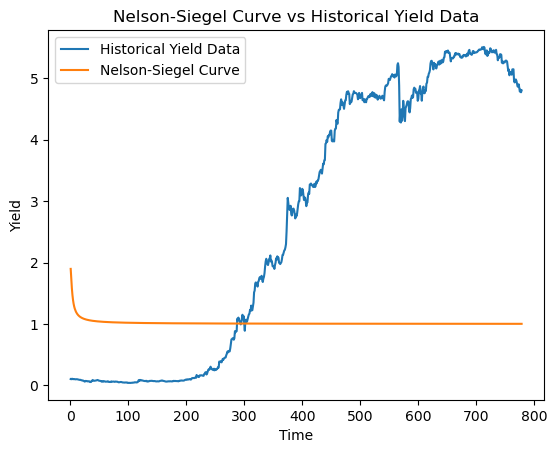

In [153]:
data = pd.read_excel('ExampleData.xlsx', index_col =None , na_values =['NA'])

# time index - daily
time = pd.date_range(start ='01/04/2021', end ='01/01/2024', freq ='D')

x_0 = np.array([1.0, 1.0, 1.0, 1.0])
alpha_0 = np.array([2, 0.0005, 0.005,0.006])

# Historical yield data
yields = np.array(data['TRUS1YT'])

# Creating an instance of NelsonSiegelModel
model = NelsonSiegelModel(-0.5, 2, 3, 4, yields)

# Computing R(t) for a specific time
t = 20
R = model.compute_R(t)
print(f"R({t}) = {R}")

# Computing f(β0, β1, β2, τ)
f = model.compute_f(t)
print(f"f(β0, β1, β2, τ) = {f}")

# Estimating parameters using gradient descent method
results = model.estimate_parameters(method='gradient_descent', starting_points = x_0, step_sizes = alpha_0, apx_LS = True)
estimation_results, optimal_params_list = results

optimal_params = optimal_params_list[0]

# Assign optimal parameters to the existing model instance
beta0, beta1, beta2, tau = optimal_params

optimal_model = NelsonSiegelModel(beta0, beta1, beta2, tau, yields)
t = 20
R = optimal_model.compute_R(t)
print(f"Optimal R({t}) = {R}")
f = optimal_model.compute_f(t)
print(f"Optimal f(β0, β1, β2, τ) = {f}")

for instance, result in estimation_results.items():
    print(f"Instance: {instance}")
    print(f"Optimal Solution: {result['Optimal Solution']}")
    print(f"Optimal Value: {result['Optimal Value']}")
    print(f"Iterations: {result['Iterations']}")
    print()

# Plotting the curve (t, R(t))
optimal_model.plot_curve()

In [154]:
data

,Date,TRUS1YT,TRUS5YT
0,2021-01-04,0.104,0.353
1,2021-01-05,0.101,0.377
2,2021-01-06,0.109,0.427
3,2021-01-07,0.107,0.458
4,2021-01-08,0.101,0.486
...,...,...,...
773,2023-12-26,4.837,3.891
774,2023-12-27,4.781,3.789
775,2023-12-28,4.813,3.840
776,2023-12-29,4.770,3.840


In [144]:
def apx_line_search(f, x, d, c = 0.5, t = 0.5, alpha_0 = 1):

    alpha= alpha_0
    f_x = f(x)
    
    def phi(a):
        return f(x+ a*d)
    
    phi_prime = approx_fprime(0, phi)
    
    while  phi(alpha) > f_x +c*alpha*phi_prime:
        alpha *= t
        
    return alpha

In [150]:
def gradient_descent(f, x_0, alpha_0 = 1, apx_LS=False, N = 50, eps = 1e-4):
    x_values = [x_0]
    f_values = [f(x_0)]

    for i in range(N):
        d = np.array([ 
            -approx_fprime(x_values[-1], f), 
            -approx_fprime(x_values[-1], f),
            -approx_fprime(x_values[-1], f),
            -approx_fprime(x_values[-1], f)])

        if apx_LS:
            alpha = apx_line_search(f, x_values[-1], d, alpha_0=alpha_0)
        else:
            alpha = alpha_0
            
        # Update x
        x_new = x_values[-1] + alpha*d
        x_values.append(x_new)
        f_values.append(f(x_new))
        
        # Stopping criterion
        if np.linalg.norm(d)<eps:
            break


   # print('Gradient descent method performed ' + str(i+1) + ' iterations')
    return x_values, f_values

In [91]:
x_0 = np.array([0, 1, 1, 1])     
alpha_0 = 1
     
def f(x):
    return np.sum(x**2)

x, val = gradient_descent(f, x_0, apx_LS=True)

display_results(x, val)

Gradient descent method performed 2 iterations
Iteration   x Values                                Function Value      
1           0.000, 1.000, 1.000, 1.000              3.000                                   
2           0.000, 0.000, 0.000, 0.000              0.000                                   
3           -0.000, -0.000, -0.000, -0.000          0.000                                   


In [4]:
def is_positive_definite(matrix, tol = 1e-04):
    
    # Compute the eigenvalues
    eigenvalues = eigh(matrix, eigvals_only = True)
    return np.all(eigenvalues > tol)

In [5]:
def approx_hessian(x, f):
    n = len(x)
    hessian = np.zeros((n, n))

    for i in range(n):
        def grad_i(y):
            return approx_fprime(y, f)[i]
        hess_i = approx_fprime(x, grad_i,epsilon=1e-6)
        
        for j in range(n):
            if i <= j:
                hessian[i, j] = hess_i[j]

                hessian[j, i] = hessian[i, j]
    return hessian

In [6]:
def newton_method(f, x_0, N=100, damping_factor = 0.5, eps=1e-6):
    x_values = [x_0]
    f_values = [f(x_0)]

    for i in range(N):
        gradient = approx_fprime(x_values[-1], f)
        hessian = approx_hessian(x_values[-1], f)

        if not is_positive_definite(hessian):
            hessian = hessian + damping_factor * np.eye(len(x_0))

        d = solve(hessian, -gradient)
        
        x_values.append(x_values[-1] + d)
        f_values.append(f(x_values[-1]))

        if np.linalg.norm(d) < eps:
            break

    print('Newton\'s method performed ' + str(i+1) + ' iterations')
    return x_values, f_values

In [14]:
# Function to nicely display the results of our algorithm
def display_results(x, values, prec=3):
    np.set_printoptions(precision=prec, suppress=True)
    
    header = f"{'Iteration':<12}{'x Values':<40}{'Function Value':<20}"
    separator = "=" * len(header)

    print(header)
    print(separator)

    for i in range(len(x)):
        x_values = ', '.join(f"{val:.{prec}f}" for val in x[i])
        value_str = f"{values[i]:.{prec}f}"

        print(f"{i + 1:<12}{x_values:<40}{value_str:<40}") 

In [16]:
def f(x):
    Q = np.diag([100, 10, 1])
    return float(x.T @ Q @ x)

x_0 = np.array([3,3,3])   
            
x, val = newton_method(f, x_0)   

display_results(x, val) 

Newton's method performed 5 iterations
Iteration   x Values                                Function Value      
1           3.000, 3.000, 3.000                     999.000                                 
2           0.094, 0.435, -9.000                    83.779                                  
3           0.000, 0.001, 0.437                     0.191                                   
4           -0.000, -0.000, -0.000                  0.000                                   
5           -0.000, -0.000, -0.000                  0.000                                   
6           -0.000, -0.000, -0.000                  0.000                                   
